### Modis Download and Processing
Script designed to process Modis images and save them one by one.

1. Find vtiles/htiles/dates for each data point
2. define windows around them, cut image
3. save images 

Potentially intended to offload eventually to azure vms

__________________________
Currently only compiled for train labels

In [88]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
from osgeo import gdal
from osgeo import gdalconst

import tempfile
import wget
import math
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

#### Modis/azure helpers


In [89]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

Ingest training + testing geodata and timestamps

Note: paths are currently absolute, but happy to make them work on both machines

In [90]:
path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))

18130


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [91]:
centroids = {} #cellid : centroid

for cell in range(len(gj['features'])):
    assert len(gj['features'][cell]['geometry']['coordinates'][0]) == 5 #coordinates have repeat on fifth, make sure this is universal
    
    cell_id =gj['features'][cell]['properties']['cell_id']
    centroid = list(np.mean(
        gj['features'][cell]['geometry']['coordinates'][0][0:4],
        axis = 0)) #lazy centroid calculation
    centroids[cell_id] = centroid

1. Ingest training, testing, submission datasets
2. Find what tiles (time, h,v) each image are stored in
3. store by cell_id, recall later for centroids

In [92]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
test =pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
submission = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/submission_format.csv")
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [93]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_y.shape[0]):
    dates[train_y.iloc[i,0]] =list(
        train_y.iloc[i,1:][~train_y.iloc[i,:].isnull()].index)#cell_id : [dates]


Compile overlapping tiles

In [94]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in dates.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

total squares: 91490


## Download relevant images

Process and save smaller images one by one

Delete after cutting up larger image

In [95]:
# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

In [121]:
product = 'MCD43A4'

#initialize empty array
dataset = np.empty((counter, 14, 21, 21)) #(image, band, row, column)
cell_ids = []

In [122]:
i = 0
for date_tile in tiles.keys():
    print(i)
    
    date = date_tile[0]
    daynum = daynum_gen(date)   
    tile_num = (date_tile[1],date_tile[2])

    folder = product + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum


    # Find all HDF files from this tile on this day
    filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
    print('Found {} matching file(s):'.format(len(filenames)))
    for fn in filenames:
        print(fn)
    file_root = filenames.copy()
    assert len(file_root) == 1 # future images may come in multiples

    # Work with the first returned URL
    file_found = False
    breaker = 1
    while not file_found and breaker <= 5:
        try:
            blob_name = filenames[0]
            file_found = True
        except IndexError:
            print("No file found: tile {} date {}".format(tile_num,daynum))
            date -= timedelta(days=1)
            daynum = daynum_gen(date) 

            breaker +=1 
            print("trying:", daynum)
    if breaker == 5:
        raise ValueError("Image", tile_num, daynum, "not found")


    # Download to a temporary file
    url = modis_blob_root + blob_name

    filename = os.path.join(temp_dir,blob_name.replace('/','_'))
    if not os.path.isfile(filename):
        wget.download(url,filename)



    #####reproject#####
    rds = rxr.open_rasterio(filename)
    image = rds.rio.reproject(dst_crs="EPSG:4326")

    #rewrite missing values for saving
    image = image.where(image != 255, other = 32767) 

    for var in image.data_vars:
        image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 

    #####create blocks around centroids#####    
    cells = tiles[date_tile]
    for cell in cells:
        center = centroids[cell]

        x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
        y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

        #subset 21x21 square
        xmin, xmax = x_idx -10 , x_idx + 11 
        ymin, ymax = y_idx -10 , y_idx + 11

        sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

        dataset[i] = sub_image.squeeze().to_array().to_numpy()
        cell_ids.append((cell, daynum)) 

        i+=1
    
#     os.remove(filename) #not removing right now

    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisImages.npy"
np.save(output_path,dataset)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_ids.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

0
Found 1 matching file(s):
MCD43A4/08/05/2018116/MCD43A4.A2018116.h08v05.006.2018125031956.hdf
1468
Found 1 matching file(s):
MCD43A4/08/05/2019075/MCD43A4.A2019075.h08v05.006.2019084034122.hdf
2937
Found 1 matching file(s):
MCD43A4/08/05/2019108/MCD43A4.A2019108.h08v05.006.2019117050241.hdf
4406
Found 1 matching file(s):
MCD43A4/08/05/2019118/MCD43A4.A2019118.h08v05.006.2019127051557.hdf
5875
Found 1 matching file(s):
MCD43A4/08/05/2019159/MCD43A4.A2019159.h08v05.006.2019168033328.hdf
6740
Found 1 matching file(s):
MCD43A4/09/05/2016094/MCD43A4.A2016094.h09v05.006.2016179235147.hdf
7910
Found 1 matching file(s):
MCD43A4/08/05/2018063/MCD43A4.A2018063.h08v05.006.2018072032322.hdf
8503
Found 1 matching file(s):
MCD43A4/08/05/2018112/MCD43A4.A2018112.h08v05.006.2018121031645.hdf
9110
Found 1 matching file(s):
MCD43A4/08/05/2018152/MCD43A4.A2018152.h08v05.006.2018161042337.hdf
10111
Found 1 matching file(s):
MCD43A4/08/05/2019074/MCD43A4.A2019074.h08v05.006.2019083173416.hdf
11863
Found 

33449
Found 1 matching file(s):
MCD43A4/08/04/2014133/MCD43A4.A2014133.h08v04.006.2016149010214.hdf
33455
Found 1 matching file(s):
MCD43A4/08/04/2014140/MCD43A4.A2014140.h08v04.006.2016149024530.hdf
33461
Found 1 matching file(s):
MCD43A4/08/04/2014147/MCD43A4.A2014147.h08v04.006.2016149044203.hdf
33467
Found 1 matching file(s):
MCD43A4/08/04/2014154/MCD43A4.A2014154.h08v04.006.2016149063309.hdf
33473
Found 1 matching file(s):
MCD43A4/08/04/2014161/MCD43A4.A2014161.h08v04.006.2016149081919.hdf
33479
Found 1 matching file(s):
MCD43A4/08/04/2014168/MCD43A4.A2014168.h08v04.006.2016149100749.hdf
33485
Found 1 matching file(s):
MCD43A4/08/04/2014175/MCD43A4.A2014175.h08v04.006.2016149115537.hdf
33491
Found 1 matching file(s):
MCD43A4/08/04/2014336/MCD43A4.A2014336.h08v04.006.2016155023441.hdf
33497
Found 1 matching file(s):
MCD43A4/08/04/2014343/MCD43A4.A2014343.h08v04.006.2016155033540.hdf
33503
Found 1 matching file(s):
MCD43A4/08/04/2014350/MCD43A4.A2014350.h08v04.006.2016155044448.hdf


33963
Found 1 matching file(s):
MCD43A4/08/04/2017115/MCD43A4.A2017115.h08v04.006.2017124031831.hdf
33970
Found 1 matching file(s):
MCD43A4/08/04/2017122/MCD43A4.A2017122.h08v04.006.2017137215108.hdf
33977
Found 1 matching file(s):
MCD43A4/08/04/2017129/MCD43A4.A2017129.h08v04.006.2017138033643.hdf
33983
Found 1 matching file(s):
MCD43A4/08/04/2017136/MCD43A4.A2017136.h08v04.006.2017145031730.hdf
33989
Found 1 matching file(s):
MCD43A4/08/04/2017143/MCD43A4.A2017143.h08v04.006.2017152031154.hdf
33994
Found 1 matching file(s):
MCD43A4/08/04/2017150/MCD43A4.A2017150.h08v04.006.2017159035503.hdf
33999
Found 1 matching file(s):
MCD43A4/08/04/2017157/MCD43A4.A2017157.h08v04.006.2017171202926.hdf
34004
Found 1 matching file(s):
MCD43A4/08/04/2017164/MCD43A4.A2017164.h08v04.006.2017173032352.hdf
34008
Found 1 matching file(s):
MCD43A4/08/04/2017171/MCD43A4.A2017171.h08v04.006.2017180024955.hdf
34013
Found 1 matching file(s):
MCD43A4/08/04/2017178/MCD43A4.A2017178.h08v04.006.2017191200545.hdf


39433
Found 1 matching file(s):
MCD43A4/08/05/2019107/MCD43A4.A2019107.h08v05.006.2019117020355.hdf
40424
Found 1 matching file(s):
MCD43A4/08/05/2019123/MCD43A4.A2019123.h08v05.006.2019133222037.hdf
41133
Found 1 matching file(s):
MCD43A4/08/05/2019164/MCD43A4.A2019164.h08v05.006.2019175183917.hdf
41842
Found 1 matching file(s):
MCD43A4/09/05/2018089/MCD43A4.A2018089.h09v05.006.2018098032703.hdf
42223
Found 1 matching file(s):
MCD43A4/09/05/2019098/MCD43A4.A2019098.h09v05.006.2019107170156.hdf
42522
Found 1 matching file(s):
MCD43A4/09/05/2019160/MCD43A4.A2019160.h09v05.006.2019169031050.hdf
42821
Found 1 matching file(s):
MCD43A4/08/05/2013093/MCD43A4.A2013093.h08v05.006.2016136055953.hdf
43338
Found 1 matching file(s):
MCD43A4/08/05/2013119/MCD43A4.A2013119.h08v05.006.2016138011612.hdf
43855
Found 1 matching file(s):
MCD43A4/08/05/2013123/MCD43A4.A2013123.h08v05.006.2016138024113.hdf
44372
Found 1 matching file(s):
MCD43A4/08/05/2013145/MCD43A4.A2013145.h08v05.006.2016138102239.hdf


48919
Found 1 matching file(s):
MCD43A4/08/05/2015055/MCD43A4.A2015055.h08v05.006.2016161114114.hdf
48950
Found 1 matching file(s):
MCD43A4/08/05/2015062/MCD43A4.A2015062.h08v05.006.2016161142815.hdf
48980
Found 1 matching file(s):
MCD43A4/08/05/2015069/MCD43A4.A2015069.h08v05.006.2016161172220.hdf
49011
Found 1 matching file(s):
MCD43A4/08/05/2015076/MCD43A4.A2015076.h08v05.006.2016161202041.hdf
49042
Found 1 matching file(s):
MCD43A4/08/05/2015083/MCD43A4.A2015083.h08v05.006.2016161231300.hdf
49072
Found 1 matching file(s):
MCD43A4/08/05/2015090/MCD43A4.A2015090.h08v05.006.2016162015824.hdf
49099
Found 1 matching file(s):
MCD43A4/08/05/2015097/MCD43A4.A2015097.h08v05.006.2016162042719.hdf
49129
Found 1 matching file(s):
MCD43A4/08/05/2015104/MCD43A4.A2015104.h08v05.006.2016162205159.hdf
49156
Found 1 matching file(s):
MCD43A4/08/05/2015111/MCD43A4.A2015111.h08v05.006.2016163002952.hdf
49186
Found 1 matching file(s):
MCD43A4/08/05/2015118/MCD43A4.A2015118.h08v05.006.2016163034725.hdf


51334
Found 1 matching file(s):
MCD43A4/08/05/2018002/MCD43A4.A2018002.h08v05.006.2018011031103.hdf
51363
Found 1 matching file(s):
MCD43A4/08/05/2018009/MCD43A4.A2018009.h08v05.006.2018018032334.hdf
51392
Found 1 matching file(s):
MCD43A4/08/05/2018016/MCD43A4.A2018016.h08v05.006.2018025030055.hdf
51421
Found 1 matching file(s):
MCD43A4/08/05/2018023/MCD43A4.A2018023.h08v05.006.2018032030949.hdf
51450
Found 1 matching file(s):
MCD43A4/08/05/2018030/MCD43A4.A2018030.h08v05.006.2018039031657.hdf
51479
Found 1 matching file(s):
MCD43A4/08/05/2018037/MCD43A4.A2018037.h08v05.006.2018046030010.hdf
51508
Found 1 matching file(s):
MCD43A4/08/05/2018044/MCD43A4.A2018044.h08v05.006.2018053031810.hdf
51537
Found 1 matching file(s):
MCD43A4/08/05/2018051/MCD43A4.A2018051.h08v05.006.2018060034800.hdf
51566
Found 1 matching file(s):
MCD43A4/08/05/2018058/MCD43A4.A2018058.h08v05.006.2018068184444.hdf
51595
Found 1 matching file(s):
MCD43A4/08/05/2018065/MCD43A4.A2018065.h08v05.006.2018074032644.hdf


54466
Found 1 matching file(s):
MCD43A4/10/04/2013148/MCD43A4.A2013148.h10v04.006.2016138121224.hdf
54515
Found 1 matching file(s):
MCD43A4/10/04/2013155/MCD43A4.A2013155.h10v04.006.2016138143711.hdf
54564
Found 1 matching file(s):
MCD43A4/10/04/2013162/MCD43A4.A2013162.h10v04.006.2016138164626.hdf
54613
Found 1 matching file(s):
MCD43A4/10/04/2013169/MCD43A4.A2013169.h10v04.006.2016138185400.hdf
54662
Found 1 matching file(s):
MCD43A4/10/04/2013176/MCD43A4.A2013176.h10v04.006.2016139014905.hdf
54711
Found 1 matching file(s):
MCD43A4/10/04/2013337/MCD43A4.A2013337.h10v04.006.2016142101905.hdf
54760
Found 1 matching file(s):
MCD43A4/10/04/2013344/MCD43A4.A2013344.h10v04.006.2016142125406.hdf
54809
Found 1 matching file(s):
MCD43A4/10/04/2013351/MCD43A4.A2013351.h10v04.006.2016142150817.hdf
54858
Found 1 matching file(s):
MCD43A4/10/04/2013358/MCD43A4.A2013358.h10v04.006.2016142172104.hdf
54907
Found 1 matching file(s):
MCD43A4/10/04/2013365/MCD43A4.A2013365.h10v04.006.2016142192044.hdf


58484
Found 1 matching file(s):
MCD43A4/10/04/2016082/MCD43A4.A2016082.h10v04.006.2016179233551.hdf
58533
Found 1 matching file(s):
MCD43A4/10/04/2016089/MCD43A4.A2016089.h10v04.006.2016180020743.hdf
58582
Found 1 matching file(s):
MCD43A4/10/04/2016096/MCD43A4.A2016096.h10v04.006.2016180043055.hdf
58631
Found 1 matching file(s):
MCD43A4/10/04/2016103/MCD43A4.A2016103.h10v04.006.2016180140701.hdf
58680
Found 1 matching file(s):
MCD43A4/10/04/2016110/MCD43A4.A2016110.h10v04.006.2016180171444.hdf
58729
Found 1 matching file(s):
MCD43A4/10/04/2016117/MCD43A4.A2016117.h10v04.006.2016180202436.hdf
58778
Found 1 matching file(s):
MCD43A4/10/04/2016124/MCD43A4.A2016124.h10v04.006.2016180231841.hdf
58827
Found 1 matching file(s):
MCD43A4/10/04/2016131/MCD43A4.A2016131.h10v04.006.2016181014041.hdf
58876
Found 1 matching file(s):
MCD43A4/10/04/2016138/MCD43A4.A2016138.h10v04.006.2016181034150.hdf
58925
Found 1 matching file(s):
MCD43A4/10/04/2016145/MCD43A4.A2016145.h10v04.006.2016181052550.hdf


62471
Found 1 matching file(s):
MCD43A4/10/04/2019022/MCD43A4.A2019022.h10v04.006.2019031035023.hdf
62520
Found 1 matching file(s):
MCD43A4/10/04/2019029/MCD43A4.A2019029.h10v04.006.2019038181352.hdf
62569
Found 1 matching file(s):
MCD43A4/10/04/2019036/MCD43A4.A2019036.h10v04.006.2019045033356.hdf
62618
Found 1 matching file(s):
MCD43A4/10/04/2019043/MCD43A4.A2019043.h10v04.006.2019052042800.hdf
62667
Found 1 matching file(s):
MCD43A4/10/04/2019050/MCD43A4.A2019050.h10v04.006.2019059220310.hdf
62716
Found 1 matching file(s):
MCD43A4/10/04/2019057/MCD43A4.A2019057.h10v04.006.2019066030757.hdf
62765
Found 1 matching file(s):
MCD43A4/10/04/2019064/MCD43A4.A2019064.h10v04.006.2019073033938.hdf
62814
Found 1 matching file(s):
MCD43A4/10/04/2019071/MCD43A4.A2019071.h10v04.006.2019080032643.hdf
62863
Found 1 matching file(s):
MCD43A4/10/04/2019078/MCD43A4.A2019078.h10v04.006.2019091174104.hdf
62912
Found 1 matching file(s):
MCD43A4/10/04/2019085/MCD43A4.A2019085.h10v04.006.2019094032249.hdf


68595
Found 1 matching file(s):
MCD43A4/09/04/2014168/MCD43A4.A2014168.h09v04.006.2016149171725.hdf
68683
Found 1 matching file(s):
MCD43A4/09/04/2014175/MCD43A4.A2014175.h09v04.006.2016149191557.hdf
68771
Found 1 matching file(s):
MCD43A4/09/04/2014336/MCD43A4.A2014336.h09v04.006.2016155061532.hdf
68859
Found 1 matching file(s):
MCD43A4/09/04/2014343/MCD43A4.A2014343.h09v04.006.2016155075150.hdf
68947
Found 1 matching file(s):
MCD43A4/09/04/2014350/MCD43A4.A2014350.h09v04.006.2016155093035.hdf
69035
Found 1 matching file(s):
MCD43A4/09/04/2014357/MCD43A4.A2014357.h09v04.006.2016155110745.hdf
69123
Found 1 matching file(s):
MCD43A4/09/04/2014364/MCD43A4.A2014364.h09v04.006.2016155125157.hdf
69211
Found 1 matching file(s):
MCD43A4/09/04/2015006/MCD43A4.A2015006.h09v04.006.2016159184445.hdf
69299
Found 1 matching file(s):
MCD43A4/09/04/2015013/MCD43A4.A2015013.h09v04.006.2016160151808.hdf
69387
Found 1 matching file(s):
MCD43A4/09/04/2015020/MCD43A4.A2015020.h09v04.006.2016160185912.hdf


75754
Found 1 matching file(s):
MCD43A4/09/04/2017108/MCD43A4.A2017108.h09v04.006.2017118203037.hdf
75841
Found 1 matching file(s):
MCD43A4/09/04/2017115/MCD43A4.A2017115.h09v04.006.2017124032856.hdf
75928
Found 1 matching file(s):
MCD43A4/09/04/2017122/MCD43A4.A2017122.h09v04.006.2017137214802.hdf
76015
Found 1 matching file(s):
MCD43A4/09/04/2017129/MCD43A4.A2017129.h09v04.006.2017138031043.hdf
76102
Found 1 matching file(s):
MCD43A4/09/04/2017136/MCD43A4.A2017136.h09v04.006.2017145034224.hdf
76189
Found 1 matching file(s):
MCD43A4/09/04/2017143/MCD43A4.A2017143.h09v04.006.2017152033415.hdf
76276
Found 1 matching file(s):
MCD43A4/09/04/2017150/MCD43A4.A2017150.h09v04.006.2017159032844.hdf
76363
Found 1 matching file(s):
MCD43A4/09/04/2017157/MCD43A4.A2017157.h09v04.006.2017171211621.hdf
76450
Found 1 matching file(s):
MCD43A4/09/04/2017164/MCD43A4.A2017164.h09v04.006.2017173035103.hdf
76537
Found 1 matching file(s):
MCD43A4/09/04/2017171/MCD43A4.A2017171.h09v04.006.2017180031049.hdf


82608
Found 1 matching file(s):
MCD43A4/09/05/2013043/MCD43A4.A2013043.h09v05.006.2016130212822.hdf
82650
Found 1 matching file(s):
MCD43A4/09/05/2013050/MCD43A4.A2013050.h09v05.006.2016131051517.hdf
82692
Found 1 matching file(s):
MCD43A4/09/05/2013057/MCD43A4.A2013057.h09v05.006.2016131162634.hdf
82734
Found 1 matching file(s):
MCD43A4/09/05/2013064/MCD43A4.A2013064.h09v05.006.2016134134216.hdf
82776
Found 1 matching file(s):
MCD43A4/09/05/2013071/MCD43A4.A2013071.h09v05.006.2016134185624.hdf
82818
Found 1 matching file(s):
MCD43A4/09/05/2013078/MCD43A4.A2013078.h09v05.006.2016135203429.hdf
82860
Found 1 matching file(s):
MCD43A4/09/05/2013085/MCD43A4.A2013085.h09v05.006.2016136033547.hdf
82902
Found 1 matching file(s):
MCD43A4/09/05/2013092/MCD43A4.A2013092.h09v05.006.2016136053946.hdf
82944
Found 1 matching file(s):
MCD43A4/09/05/2013099/MCD43A4.A2013099.h09v05.006.2016136071432.hdf
82986
Found 1 matching file(s):
MCD43A4/09/05/2013106/MCD43A4.A2013106.h09v05.006.2016137144810.hdf


86052
Found 1 matching file(s):
MCD43A4/09/05/2015342/MCD43A4.A2015342.h09v05.006.2016171054741.hdf
86094
Found 1 matching file(s):
MCD43A4/09/05/2015349/MCD43A4.A2015349.h09v05.006.2016171081730.hdf
86136
Found 1 matching file(s):
MCD43A4/09/05/2015356/MCD43A4.A2015356.h09v05.006.2016171104134.hdf
86178
Found 1 matching file(s):
MCD43A4/09/05/2015363/MCD43A4.A2015363.h09v05.006.2016171130005.hdf
86220
Found 1 matching file(s):
MCD43A4/09/05/2016005/MCD43A4.A2016005.h09v05.006.2016174095514.hdf
86262
Found 1 matching file(s):
MCD43A4/09/05/2016012/MCD43A4.A2016012.h09v05.006.2016174130615.hdf
86304
Found 1 matching file(s):
MCD43A4/09/05/2016019/MCD43A4.A2016019.h09v05.006.2016174162919.hdf
86346
Found 1 matching file(s):
MCD43A4/09/05/2016026/MCD43A4.A2016026.h09v05.006.2016174194037.hdf
86388
Found 1 matching file(s):
MCD43A4/09/05/2016033/MCD43A4.A2016033.h09v05.006.2016174223918.hdf
86430
Found 1 matching file(s):
MCD43A4/09/05/2016040/MCD43A4.A2016040.h09v05.006.2016175014104.hdf


89545
Found 1 matching file(s):
MCD43A4/09/05/2018128/MCD43A4.A2018128.h09v05.006.2018155194550.hdf
89588
Found 1 matching file(s):
MCD43A4/09/05/2018135/MCD43A4.A2018135.h09v05.006.2018157023244.hdf
89631
Found 1 matching file(s):
MCD43A4/09/05/2018142/MCD43A4.A2018142.h09v05.006.2018157193116.hdf
89674
Found 1 matching file(s):
MCD43A4/09/05/2018149/MCD43A4.A2018149.h09v05.006.2018158182503.hdf
89717
Found 1 matching file(s):
MCD43A4/09/05/2018156/MCD43A4.A2018156.h09v05.006.2018166210541.hdf
89760
Found 1 matching file(s):
MCD43A4/09/05/2018163/MCD43A4.A2018163.h09v05.006.2018172032447.hdf
89803
Found 1 matching file(s):
MCD43A4/09/05/2018170/MCD43A4.A2018170.h09v05.006.2018179150235.hdf
89846
Found 1 matching file(s):
MCD43A4/09/05/2018177/MCD43A4.A2018177.h09v05.006.2018186223911.hdf
89889
Found 1 matching file(s):
MCD43A4/09/05/2018338/MCD43A4.A2018338.h09v05.006.2018347031816.hdf
89932
Found 1 matching file(s):
MCD43A4/09/05/2018345/MCD43A4.A2018345.h09v05.006.2018355202818.hdf


## Sanity check if desired

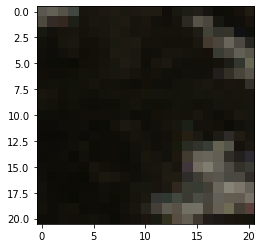

In [125]:
def plot_image(image):
    image[image == image.max()] = image.max()/3
    image = image/image.max()
    r = image[12]; g = image[2]; b = image[1]
    
    plt.imshow(np.dstack([r,g,b]))

plot_image(dataset[10001])

91490